In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import pickle
import requests
import json
import re
from pathlib import Path

from skylark import skylark_root

data_dir = skylark_root / "data"
figure_dir = data_dir / "figures" / "pareto_speedups_updated"
figure_dir.mkdir(exist_ok=True, parents=True)

plt.style.use("seaborn-bright")
plt.set_cmap("plasma")

<Figure size 432x288 with 0 Axes>

In [ ]:
# rows = []
# for i in range(15):
#     print("Loading", i)
#     file = f"/home/ubuntu/pareto_data/{i}.pkl"
#     with open(file, "rb") as f:
#         for i in pickle.load(f):
#             x = i.__dict__.copy()
#             for k, v in x['problem'].__dict__.items():
#                 x[f"problem_{k}"] = v
#             del x['problem']
#             rows.append(x)
# df = pd.DataFrame(rows)

In [ ]:
# df_save = df.copy()
# df_save = df.drop(columns=["var_edge_flow_gigabits", "var_conn", "var_instances_per_region", "cost_egress_by_edge"])
# df_save.to_parquet(Path("~/pareto_data") / "df.parquet")


In [17]:
df = pd.read_parquet(data_dir / "df_sweep.parquet")
df = df.drop(columns=["problem_const_throughput_grid_gbits", "problem_const_cost_per_gb_grid"]).dropna()
df['throughput_achieved_gbits'] = df['throughput_achieved_gbits'].apply(lambda x: x[0])
df["problem_src_region"] = df["problem_src"].apply(lambda x: x.split("-")[0])
df["problem_dst_region"] = df["problem_dst"].apply(lambda x: x.split("-")[0])
df["cost_speedup"] = df["baseline_cost"] / df["cost_total"]
df["throughput_speedup"] = df["baseline_throughput_gbits"] / df["throughput_achieved_gbits"]

,is_feasible,throughput_achieved_gbits,cost_egress,cost_instance,cost_total,transfer_runtime_s,baseline_throughput_gbits,baseline_cost,problem_src,problem_dst,problem_required_throughput_gbits,problem_gbyte_to_transfer,problem_instance_limit,problem_const_instance_cost_multipler,problem_aws_instance_throughput_limit,problem_gcp_instance_throughput_limit,problem_azure_instance_throughput_limit
3,True,5.050505,0.120000,0.002710,0.122710,1.584000,11.0824,0.001235,aws:ap-southeast-1,azure:eastus,5.050505,1,4,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
6,True,6.060606,0.050000,0.001129,0.051129,1.320000,97.3784,0.000281,azure:westeurope,azure:canadacentral,6.060606,1,8,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
13,True,10.606061,0.080000,0.001936,0.081936,0.754286,19.3660,0.000707,gcp:us-west1-a,gcp:asia-northeast1-a,10.606061,1,4,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
14,True,22.979798,0.109415,0.001042,0.110458,0.348132,18.6782,0.000366,azure:koreacentral,azure:canadacentral,22.979798,1,2,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
17,True,15.151515,0.090000,0.001807,0.091807,0.528000,19.5316,0.000701,azure:eastus2,aws:eu-west-3,15.151515,1,4,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491512,True,2.525253,0.020000,0.002710,0.022710,3.168000,12.8744,0.000532,gcp:europe-west2-a,gcp:europe-west1-b,2.525253,1,2,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
491514,True,3.787879,0.120000,0.001807,0.121807,2.112000,7.6598,0.000894,aws:me-south-1,gcp:europe-west2-a,3.787879,1,2,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
491516,True,1.893939,0.020000,0.003614,0.023614,4.224000,4.3098,0.000794,aws:eu-north-1,aws:eu-west-3,1.893939,1,1,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"
491518,True,10.353535,0.090000,0.001322,0.091322,0.772683,11.6040,0.000590,azure:eastus,gcp:europe-west2-a,10.353535,1,2,1.0,"[5, 10]","[8.0, 12.5]","[12.5, 12.5]"


Plotting instance_limit 1
Plotting instance_limit 2
Plotting instance_limit 4
Plotting instance_limit 8


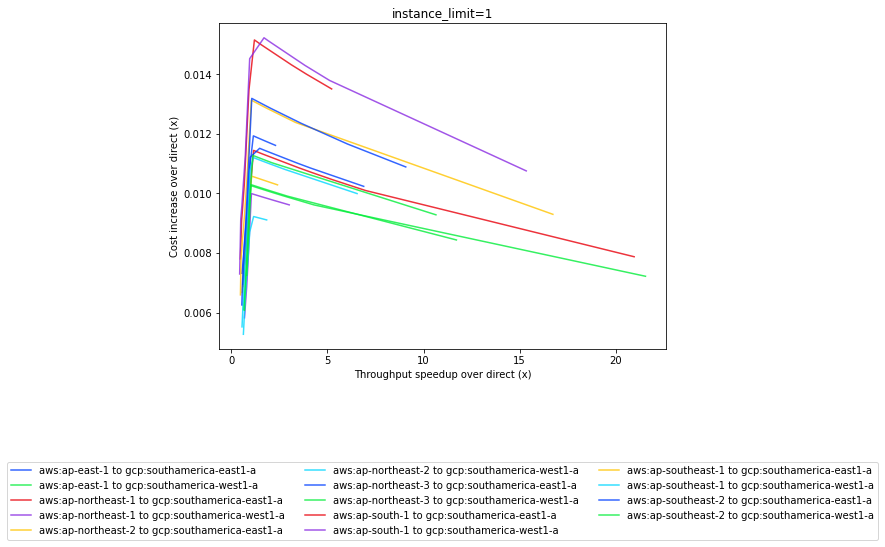

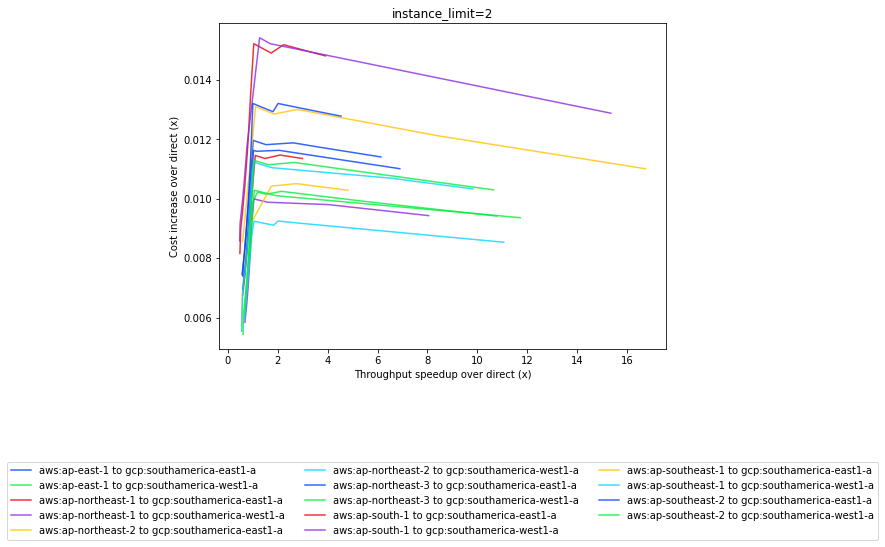

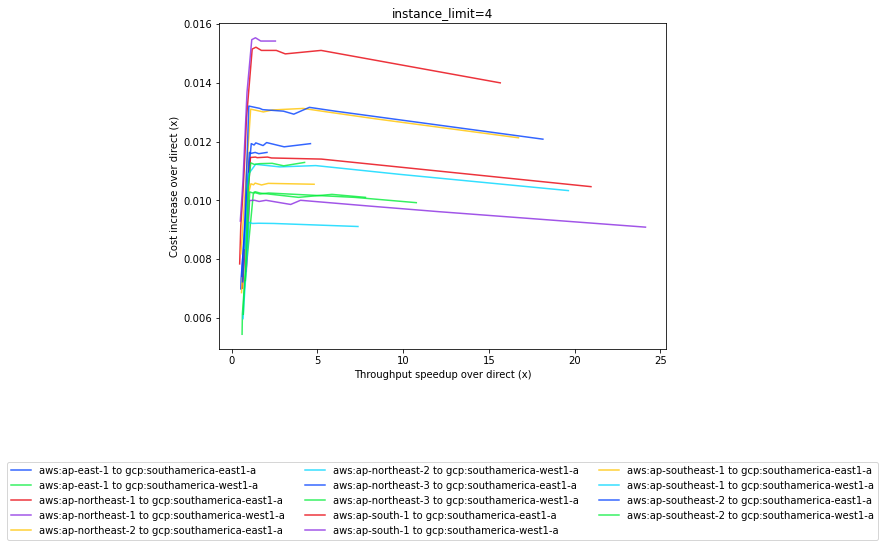

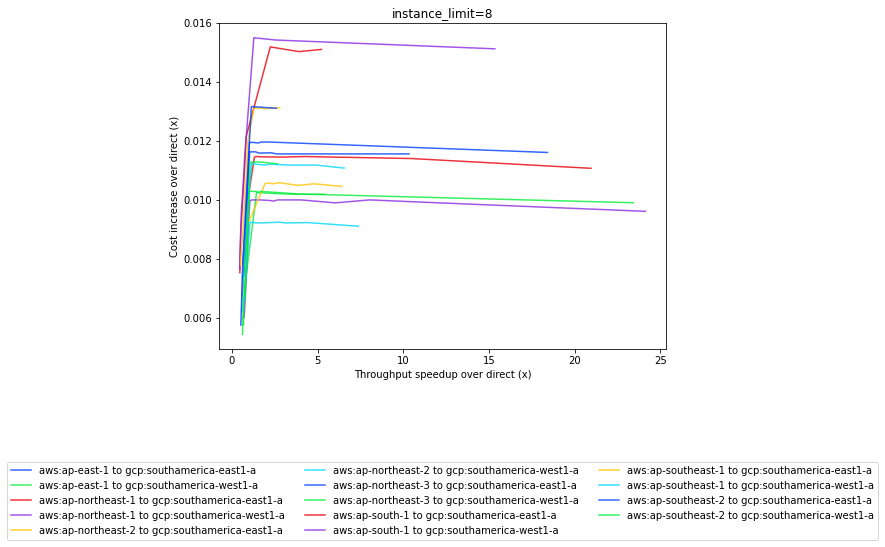

In [20]:
# gcp:us-central1-c -> "gcp:us"


# select problem_src_region = "aws:ap", problem_dst_region = "gcp:southamerica"
src_regions = df["problem_src_region"].unique()
dst_regions = df["problem_dst_region"].unique()

# make jupyter dropdown for src_region, dst_region


# plot scatter w/ cost_factor vs throughput_speedup, color by src with legend
for instance_limit, df_limit in df.groupby("problem_instance_limit"):
    print("Plotting instance_limit", instance_limit)
    fig, ax = plt.subplots(figsize=(8, 6))
    for (src_region, dst_region), df_grouped in df_limit.groupby(["problem_src", "problem_dst"]):
        df_grouped.sort_values(by="throughput_achieved_gbits", inplace=True)
        label = "{} to {}".format(src_region, dst_region)
        sns.lineplot(x="throughput_speedup", y="cost_speedup", data=df_grouped, ax=ax, label=label, alpha=0.8, markers=True)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_title("instance_limit={}".format(instance_limit))
    ax.set_xlabel("Throughput speedup over direct (x)")
    ax.set_ylabel("Cost increase over direct (x)")

    # white background (no transparency)
    fig.set_facecolor("white")

    fig.savefig(figure_dir / f"pareto_speedups_{instance_limit}.png", bbox_inches="tight", dpi=300)
    fig.savefig(figure_dir / f"pareto_speedups_{instance_limit}.pdf", bbox_inches="tight", dpi=300)

In [ ]:
df.describe()